# <div align='center'> **Analyzing Data from LinkedIn Job Postings**


<div align='center'> December 5th, 2023

**Brigham Young University**

```
Sophie Carter
Morgan Nielsen 
Michelle Wang
Sarah Winters
```

In [13]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import r2_score
from itertools import combinations
import statsmodels.api as sm
from sklearn import linear_model
import us
from us import states


# **Introduction**

## **Background**

&emsp; &nbsp; LinkedIn, established in 2002, has evolved into a pivotal platform for professionals to connect, network, and explore employment opportunities. With over 800 million members worldwide, LinkedIn remains a powerhouse in the realm of professional social networking. The platform serves as a dynamic repository of job postings, providing a comprehensive snapshot of the global employment landscape. Job overviews on LinkedIn encapsulate a wealth of information, offering detailed insights into the skill sets, qualifications, and responsibilities associated with various positions. As the professional world continues to embrace digital transformation, the sheer volume of data generated by LinkedIn job postings becomes an invaluable resource for researchers and organizations seeking to gain a nuanced understanding of labor market trends.


## **Motivation**

&emsp; &nbsp; As college seniors who are navigating challenges of job applications for entry-level positions, our motivation for undertaking this project is deeply rooted in our personal experiences and the collective anxiety associated with the transition from academia to the professional sphere. Recognizing the significance of securing gainful employment post-graduation, we, as a group, sought to explore a topic that not only resonated with our immediate concerns but also allowed us to leverage our skills in data analysis and machine learning. Initially, our research led us to consider mapping unemployment trends among newly graduated students. However, we encountered obstacles in obtaining clear and comprehensive data, coupled with a lack of robust techniques to effectively analyze this aspect of the job market.
Upon furthering our research, we found a dataset containing LinkedIn job postings from the year 2023. This discovery prompted a shift in our focus, steering us towards the prospect of predicting salary ranges for entry-level positions—a pivotal aspect of the employment equation that directly impacts our cohort. The availability of real-time data from a platform as influential as LinkedIn presented a unique opportunity to apply machine learning algorithms to decipher patterns and trends in salary expectations. Our motivation stems from a desire to contribute not only to our academic pursuits but also to address a practical and immediate concern shared by many in our position—deciphering the salary landscape of entry-level job opportunities in 2023.

## **Overview**

&emsp; &nbsp; We had three main questions that we wanted to answer throughout this paper. First, we wanted to determine if our dataset could help us create a model to predict the formatted experience level based on the minimum and maximum salaries. We also wanted to observe the other way around—how our model can predict salary ranges based on information like location, experience level, and description. Finally, we wanted to determine common words in job descriptions and necessary skills, to be able to determine entry-level jobs; our greatest interest here is specifically in entry-level jobs, since in our personal job hunting experiences, we have run across job descriptions that contradict the formatted experience level. Though we had three questions in mind, we focus the most time on our first question, and hope to be able to answer the other two in the future.


# **The Data**

## **Data Description**

&emsp; &nbsp; Originally, we were going to use two datasets—one about underemployment and one that included LinkedIn job postings from 2023. However, we realized after our proposal and looking more closely at the data that the underemployment dataset wouldn’t be very relevant with the information we could extract from the second dataset. The LinkedIn dataset is a record of over 33,000 job postings spread out between two separate days in 2023 that are months apart. The dataset includes 27 features total, though we mostly used minimum salary, maximum salary, formatted experience level, job description, location, and necessary skills listed. 

## **Data Preparation**

&emsp; &nbsp; Unfortunately, many features in the dataset have hundreds or thousands of NaN values. To observe which columns had the most missing data, we used the pandas feature ```.isna().sum()``` to observe the list of features and the number of missing values listed for each. 

In [6]:
job_postings_data = pd.read_csv('job_postings.csv')

In [7]:
# look at the missing data
missing_data = job_postings_data.isna().sum()
# print(missing_data)

&emsp; &nbsp; The most important data to us were those corresponding with description, salary, experience level, and skills. Because of this, we originally looked at the rows that had this data missing, and dropped the NaN values for description, and then the data for maximum salary. After looking at the missing data again, we noticed that the NaN values for maximum salary were the same rows as the missing minimum salary data, so there weren't any missing values in either salary column after dropping the missing maximums. The median salary data felt less important to our goals, so we decided to also drop those values as well. After dropping these NaN values, we felt there were still sufficient data for our analysis, which was part of the reason we felt this dataset was adequate for the predictions and observations we were going to make. However, the formatted experience level column had information we wanted, so we decided to also drop the rows that had NaN values in this column. 

In [8]:
job_postings_data = job_postings_data[job_postings_data['description'].notna()]

# now drop the max, min salaries with NaN values
job_postings_data = job_postings_data[job_postings_data['max_salary'].notna()]

# drop the missing formatted experience data
job_postings_data = job_postings_data[job_postings_data['formatted_experience_level'].notna()]
# we only want to look at the salary that's yearly
job_postings_data['pay_period'].value_counts()
job_postings_data['formatted_work_type'].value_counts()

# filter out the data to just be full-time
full_time_mask = job_postings_data['formatted_work_type'] == 'Full-time'
full_time_data = job_postings_data[full_time_mask]
# print(full_time_data['pay_period'].value_counts())

# multiply the monthly max and min salary  by 12
monthly_mask = full_time_data['pay_period'] == 'MONTHLY'
full_time_data.loc[monthly_mask, ['min_salary', 'max_salary']] *= 12

# multiply the hourly data
hourly_mask = full_time_data['pay_period'] == 'HOURLY'
full_time_data.loc[hourly_mask, ['min_salary', 'max_salary']] *= (40 * 52)

# print(full_time_data.columns)

# now observe all the columns that still have missing data
missing_data = full_time_data.isna().sum()
# print(missing_data)

&emsp; &nbsp; Usually we would want to replace the missing data with something that still had value to our model, so we wouldn't lose any information that could assist with our predictions. However, since our main question ended up surrounding the maximum salary, minimum salary, and formatted experience level columns, we decided that dropping the missing data was the best option, since we could not think of appropriate replacements that would add any use. After dropping these values, we later created one-hot encodings for each type of experience level, so we could go through each one and observe the accuracy of our model’s predictions.


# **Analysis**

&emsp; &nbsp; Our analysis focuses on classifying the six different experience types: are Entry level, Associate, Intern, Executive, Mid-senior level, and Director. Each level of experience has different expected salaries and distributions, so we wanted to observe these differences. It’s expected that as the max salary goes up the more likely the required experience is higher. This prediction is sound while looking at the histograms from some of the data. The director jobs have an expected salary value a lot higher than the entry level jobs. As there is a lot of missing data, we started our predictions based on just entry level jobs because that was our interest, but found that other experience levels are more predictable with our methods.

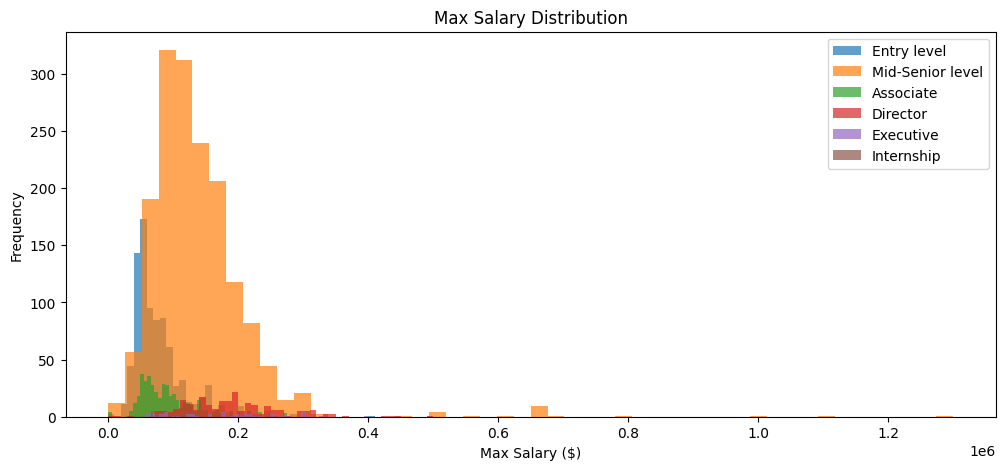

In [5]:
# using the modified job postings data from section 2.2
level_data = full_time_data.groupby("formatted_experience_level")

# analyze each experience level 
levels = ["Entry level", "Mid-Senior level", "Associate", "Director", "Executive", "Internship"]

# plot the max salary based on experience level
plt.figure(figsize=(12, 5))
for level in levels:
    data = level_data.get_group(level)
    data["max_salary"].plot(kind="hist", y="max_salary", label=level, bins=50, alpha=0.7)

plt.xlabel("Max Salary ($)")
plt.title("Max Salary Distribution")
plt.legend()

## **Random Forest and Grid Search**

In our efforts to be able to classify the data into the different experience levels, we first used the random forest classifier to evaluate the precision, recall, and f1 score for each. To do this, we split our data into testing and training sets, where we used 80% for training and 20% for testing. We then created a classification report so we could focus on the two experience levels that had the highest precision, recall, and f1-score.

In [6]:
# create a df with just the salary
salary_columns = full_time_data[["max_salary", "min_salary"]]

# create our X and y
X = salary_columns
y = full_time_data["formatted_experience_level"]

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
forest_model = RandomForestClassifier()
forest_model.fit(X_train, y_train)

predictions = forest_model.predict(X_test)
print(f"RandomForestClassifier Classification: \n {classification_report(y_test, predictions)}")


RandomForestClassifier Classification: 
                   precision    recall  f1-score   support

       Associate       0.29      0.24      0.26        89
        Director       0.42      0.18      0.25        55
     Entry level       0.67      0.62      0.64       180
       Executive       0.00      0.00      0.00         4
      Internship       0.00      0.00      0.00         3
Mid-Senior level       0.66      0.79      0.72       316

        accuracy                           0.61       647
       macro avg       0.34      0.30      0.31       647
    weighted avg       0.58      0.61      0.59       647



We can see that the support for Entry level and Mid-Senior level jobs are the highest, as well as the accompanying precision, recall and f1-score values, so we decided to look at them individually by creating a one hot encoding and initializing a random forest model for these columns. Since we wanted the most accurate models possible, we performed a grid search for both entry level and mid-senior level jobs. With this grid search, we can see which parameters create the best model for each level, and find the accuracy and confusion matrix of the predictions.

In [7]:
one_hot_data = pd.get_dummies(full_time_data, columns=['formatted_experience_level'], dtype=int)

In [8]:
# create a function for predicting based off of formatted experience level
def experience_level_predictions(experience_level):
    X = one_hot_data[['min_salary', 'max_salary']]
    y = one_hot_data[experience_level]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    forest_model = RandomForestClassifier()
    forest_model.fit(X_train, y_train)
    # now run a grid search with different parameters
    param_grid = {"n_estimators": [100, 200],
                "max_depth": [4,5,6,7,8],
                "criterion": ['gini', 'entropy']}
    forest_grid = GridSearchCV(forest_model, param_grid, scoring='f1')
    # run the search
    forest_grid.fit(X_train, y_train)
    print(f"Best Parameters: {forest_grid.best_params_}\n")
    print(f"Best Score: {forest_grid.best_score_}\n")

    # predict the labels for the test set
    forest_grid_predicted = forest_grid.predict(X_test)
    # create the confusion matrix
    confusion = confusion_matrix(y_test, forest_grid_predicted)
    print(f"Confusion Matrix: \n{confusion}")

To be able to look at the separate experience levels, we created a one-hot encoding, and ran the above function for ```formatted_experience_level_Entry level``` and ```formatted_experience_level_Mid-Senior level```.

Entry Level

In [9]:
experience_level_predictions('formatted_experience_level_Entry level')

Best Parameters: {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 100}

Best Score: 0.6025449849746389

Confusion Matrix: 
[[436  31]
 [ 82  98]]


Mid-Senior Level

In [10]:
experience_level_predictions('formatted_experience_level_Mid-Senior level')

Best Parameters: {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 100}

Best Score: 0.7252104049939352

Confusion Matrix: 
[[204 127]
 [ 64 252]]


From this, we can conclude that with minimum and maximum salary as our independent variables, our model has 59.3% accuracy in predicting entry level jobs 72% accuracy in predicting mid-senior level positions. We also see that the best parameters are the same for each of the grid searches, with gini as our best criterion, a maximum depth of 8, and 200 estimators.

## **Logistic Regression**

Using Logistic regression to use salary to predict the experience levels.

formatted_experience_level
Mid-Senior level    1642
Entry level          872
Associate            442
Director             216
Executive             46
Internship            17
Name: count, dtype: int64
Model accuracy:  0.4884080370942813


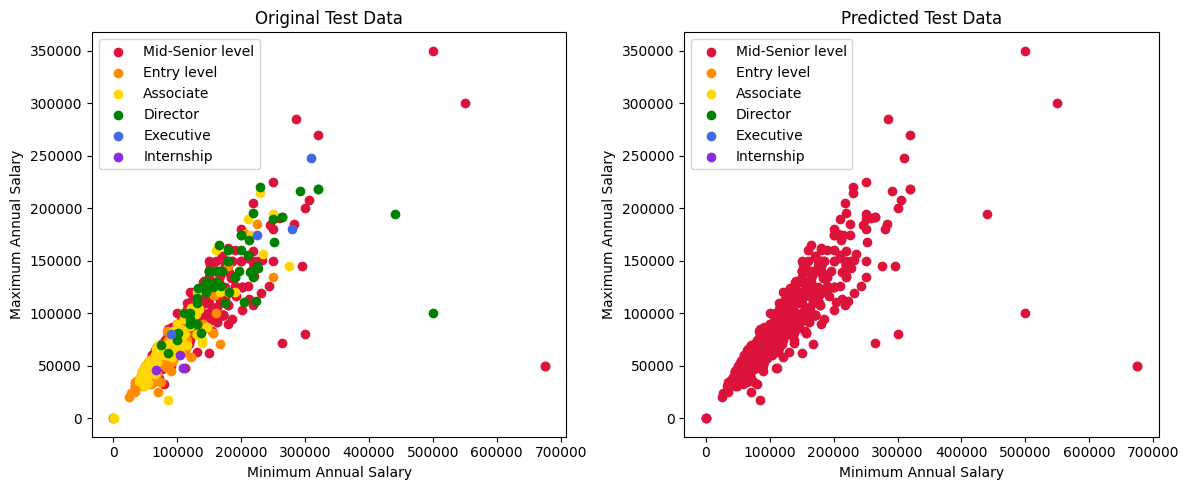

In [11]:
# using the training and testing data from above
# create our X and y
X = salary_columns
y = full_time_data["formatted_experience_level"]

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# use LogisticRegression
model = LogisticRegression(
                multi_class='multinomial',
                fit_intercept=True).fit(X_train, y_train) # add constant feature
prediction_labels = model.predict(X_test)
# print(X_test)
# plot the original data
print(full_time_data['formatted_experience_level'].value_counts())
label_color_dict = {'Mid-Senior level': 'crimson',
             'Entry level': 'darkorange',
             'Associate': 'gold',
             'Director': 'green',
             'Executive': 'royalblue',
             'Internship': 'blueviolet'}


plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
for key, value in label_color_dict.items():
    indices = y_test.values == key
    plt.scatter(X_test.values[indices, 0], X_test.values[indices, 1], label=f'{key}', c=value)
plt.xlabel("Minimum Annual Salary")
plt.ylabel("Maximum Annual Salary")
plt.title("Original Test Data")
plt.legend()

# now with predicted labels
plt.subplot(1,2,2)
for key, value in label_color_dict.items():
    indices = prediction_labels == key
    plt.scatter(X_test.values[indices, 0], X_test.values[indices, 1], label=f'{key}', c=value)
plt.xlabel("Minimum Annual Salary")
plt.ylabel("Maximum Annual Salary")
plt.title("Predicted Test Data")
plt.legend()
plt.tight_layout()

print("Model accuracy: ", accuracy_score(y_test.values, prediction_labels))

Now do the same thing as above, but just for Entry level and Mid-Senior level.

formatted_experience_level
Mid-Senior level    1642
Entry level          872
Name: count, dtype: int64
Model accuracy:  0.6322067594433399


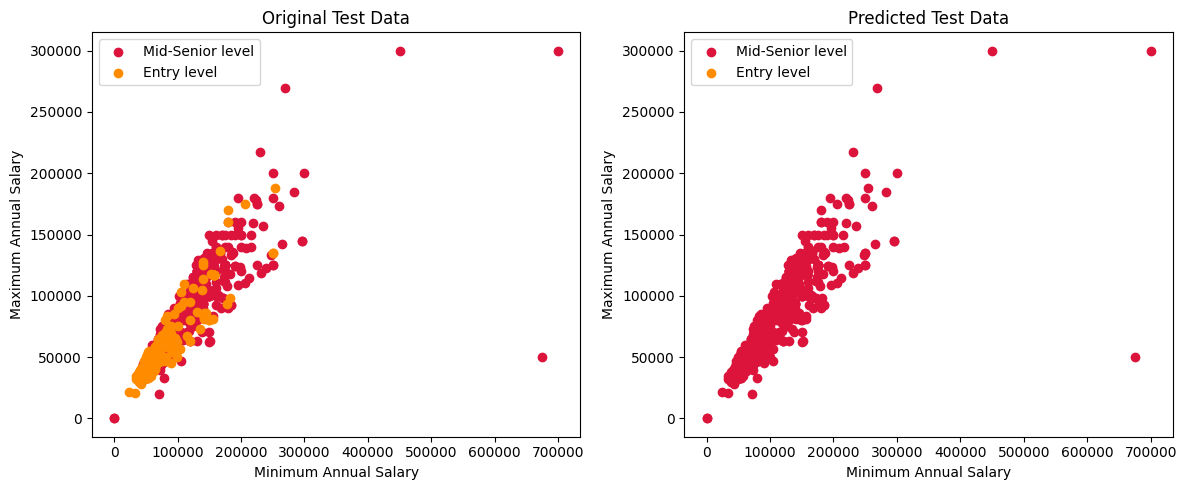

In [12]:
# now we just want to see mid-senior level and entry level
experience_level_mask = (full_time_data["formatted_experience_level"] == 'Mid-Senior level') | (full_time_data["formatted_experience_level"] == 'Entry level')
dataframe_with_mask = full_time_data[experience_level_mask]
# create our X and y
salary_columns = dataframe_with_mask[["max_salary", "min_salary"]]
X = salary_columns
y = dataframe_with_mask['formatted_experience_level']

print(dataframe_with_mask['formatted_experience_level'].value_counts())

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# use LogisticRegression
model = LogisticRegression(
                multi_class='multinomial',
                fit_intercept=True).fit(X_train, y_train) # add constant feature
prediction_labels = model.predict(X_test)
# print(X_test)
# plot the original data
# print(full_time_data['formatted_experience_level'].value_counts())
label_color_dict = {'Mid-Senior level': 'crimson',
             'Entry level': 'darkorange'}

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
for key, value in label_color_dict.items():
    indices = y_test.values == key
    plt.scatter(X_test.values[indices, 0], X_test.values[indices, 1], label=f'{key}', c=value)
plt.xlabel("Minimum Annual Salary")
plt.ylabel("Maximum Annual Salary")
plt.title("Original Test Data")
plt.legend()

# now with predicted labels
plt.subplot(1,2,2)
for key, value in label_color_dict.items():
    indices = prediction_labels == key
    plt.scatter(X_test.values[indices, 0], X_test.values[indices, 1], label=f'{key}', c=value)
plt.xlabel("Minimum Annual Salary")
plt.ylabel("Maximum Annual Salary")
plt.title("Predicted Test Data")
plt.legend()
plt.tight_layout()

print("Model accuracy: ", accuracy_score(y_test.values, prediction_labels))

Doing Binary classification-- Mid-Senior level and not Mid-Senior level

Model accuracy:  0.4884080370942813


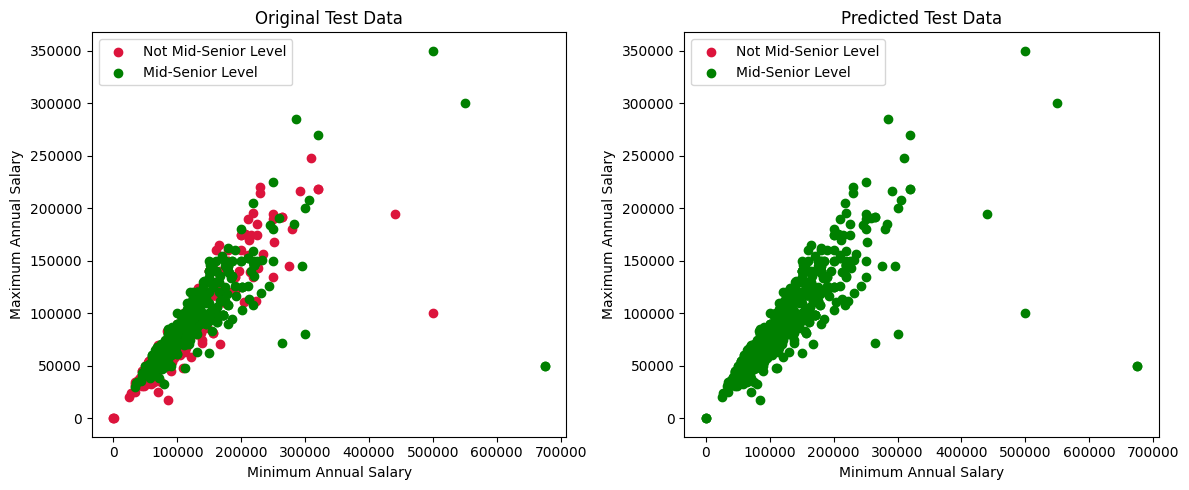

In [13]:
# binarize the Mid-Senior level data 
one_hot_data = pd.get_dummies(full_time_data, columns=['formatted_experience_level'], dtype=int)
# create a df with just the salary
salary_columns = one_hot_data[["max_salary", "min_salary"]]
X = salary_columns
y = one_hot_data['formatted_experience_level_Mid-Senior level']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# use LogisticRegression
model = LogisticRegression(fit_intercept=True).fit(X_train, y_train) # add constant feature
prediction_labels = model.predict(X_test)
# plot the original data
label_color_dict = {0: 'crimson', 1: 'green'}

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
for key, value in label_color_dict.items():
    indices = y_test.values == key
    if key:
        plot_label = 'Mid-Senior Level'
    else:
        plot_label = 'Not Mid-Senior Level'
    plt.scatter(X_test.values[indices, 0], X_test.values[indices, 1], label=plot_label, c=value)
plt.xlabel("Minimum Annual Salary")
plt.ylabel("Maximum Annual Salary")
plt.title("Original Test Data")
plt.legend()

# now with predicted labels
plt.subplot(1,2,2)
for key, value in label_color_dict.items():
    indices = prediction_labels == key
    if key:
        plot_label = 'Mid-Senior Level'
    else:
        plot_label = 'Not Mid-Senior Level'
    plt.scatter(X_test.values[indices, 0], X_test.values[indices, 1], label=plot_label, c=value)
plt.xlabel("Minimum Annual Salary")
plt.ylabel("Maximum Annual Salary")
plt.title("Predicted Test Data")
plt.legend()
plt.tight_layout()

print("Model accuracy: ", accuracy_score(y_test.values, prediction_labels))



## **More Feature Engineering for Predicting Min/Max Salary Using Experience Level and Location**

insert google doc paragraphs in appropriate places

In [19]:
full_time_data = full_time_data[full_time_data['max_salary'].notna()]
full_time_data = full_time_data[full_time_data['min_salary'].notna()]

# cleaning indpt vars
indptvars1 = list(full_time_data.columns)
remove = ['job_id', 'description', 'title', 'applies', 'views', 'job_posting_url', 'application_url','med_salary',\
          'listed_time', 'expiry','skills_desc', 'original_listed_time','closed_time', 'posting_domain',\
          'company_id', 'remote_allowed','application_type', 'work_type', 'currency','compensation_type',\
         'sponsored','pay_period','formatted_work_type']
for item in remove:
    indptvars1.remove(item)

pred_data = full_time_data[list(indptvars1)]

In [20]:
def split_city_state(location):
    """
    Returns state if input format is (city, state). Else returns the city.
    """
    if location is not None:
        words = location.split(', ')
        if len(words) == 2:
            city, state = words
            if us.states.lookup(state):
                return us.states.lookup(state).name
            elif state == 'United States':
                return city
            else:
                return city
    return None

In [21]:
def get_region(state):
    """
    Returns respective CONUS region to input state.
    """
    region_mapping = {
        'Alabama': 'Southeast','Alaska': 'West','Arizona': 'West','Arkansas': 'Southwest','California': 'West',
        'Colorado': 'Southwest','Connecticut': 'Northeast','Delaware': 'Northeast','District of Columbia': 'Northeast',
        'Florida': 'Southeast','Georgia': 'Southeast','Hawaii': 'West','Idaho': 'West','Illinois': 'Midwest',
        'Indiana': 'Midwest','Iowa': 'Midwest','Kansas': 'Midwest','Kentucky': 'Southeast','Louisiana': 'Southwest',
        'Maine': 'Northeast','Maryland': 'Northeast','Massachusetts': 'Northeast','Michigan': 'Midwest',
        'Minnesota': 'Midwest','Mississippi': 'Southeast','Missouri': 'Midwest','Montana': 'Southwest',
        'Nebraska': 'Midwest','Nevada': 'West','New Hampshire': 'Northeast','New Jersey': 'Northeast',
        'New Mexico': 'Southwest','New York': 'Northeast','North Carolina': 'Southeast','North Dakota': 'Southwest',
        'Ohio': 'Midwest','Oklahoma': 'Southwest','Oregon': 'West','Pennsylvania': 'Northeast',
        'Rhode Island': 'Northeast','South Carolina': 'Southeast','South Dakota': 'Southwest','Tennessee': 'Southeast',
        'Texas': 'Southwest','Utah': 'Southwest','Vermont': 'Northeast','Virginia': 'Northeast',
        'Washington': 'West','West Virginia': 'Northeast','Wisconsin': 'Midwest','Wyoming': 'Southwest',
    }

    return region_mapping.get(state, state)



In [22]:
prediction_data = pred_data.assign(state=pred_data['location'].apply(split_city_state)) # get states

In [23]:
# assign unformatted cities to states
prediction_data.loc[prediction_data['state'] == 'Rochester', 'state'] = 'New York'
prediction_data.loc[prediction_data['state'] == 'Greater Bloomington', 'state'] = 'Indiana'
prediction_data.loc[prediction_data['state'] == 'Charleston', 'state'] = 'South Carolina'
prediction_data.loc[prediction_data['state'] == 'Albany', 'state'] = 'New York'
prediction_data.loc[prediction_data['state'] == 'Hilton Head Island', 'state'] = 'South Carolina'
prediction_data.loc[prediction_data['state'] == 'Columbia', 'state'] = 'South Carolina'
prediction_data.loc[prediction_data['state'] == 'Greater Yuma', 'state'] = 'Arizona'
prediction_data.loc[prediction_data['state'] == 'Columbus', 'state'] = 'Ohio'
prediction_data.loc[prediction_data['state'] == 'Portland', 'state'] = 'Oregon'
prediction_data.loc[prediction_data['state'] == 'Austin', 'state'] = 'Texas'
prediction_data.loc[prediction_data['state'] == 'San Antonio', 'state'] = 'Texas'
places_to_drop = ['Springfield', None]
prediction_data.drop(prediction_data[prediction_data['state'].isin(places_to_drop)].index, inplace=True)

In [24]:
prediction_data = prediction_data.assign(region=prediction_data['state'].apply(get_region)) # get regions
prediction_data = prediction_data.drop('location', axis=1) # drop location column
clean_pred_data = prediction_data.drop('state', axis=1) # drop state column

In [25]:
clean_pred_data 

,max_salary,min_salary,formatted_experience_level,region
23,170976.00,98640.00,Mid-Senior level,Northeast
24,95680.00,39520.00,Mid-Senior level,West
27,79541.00,55280.00,Entry level,West
28,79541.00,55280.00,Entry level,West
29,117510.65,91010.65,Mid-Senior level,West
...,...,...,...,...
15865,62400.00,41600.00,Mid-Senior level,Midwest
15870,85000.00,75000.00,Mid-Senior level,Northeast
15871,70000.00,60000.00,Mid-Senior level,Southwest
15878,105200.00,91900.00,Mid-Senior level,West


In [26]:
# extract dependent variables
y1 = clean_pred_data["min_salary"]
y2 = clean_pred_data["max_salary"]

# have object types so need to one-hot encode and make numeric
pred_hot_data = pd.get_dummies(clean_pred_data, columns=['region','formatted_experience_level'],drop_first=True)
pred_hot_data = pred_hot_data.astype(float)
indptvars = list(pred_hot_data.columns)
indptvars.remove('min_salary')
indptvars.remove('max_salary')

In [27]:
# get combinations of these indpt vars
all_combos = [] # list of independent vars combos
for i in range(1, len(indptvars) + 1):
    all_combos.extend(combinations(indptvars, i))

## Predicting Min Salary Using Experience Level and Location

In [28]:
# build models for each combination of indpt vars
# find models for best R^2, best AIC, and best BIC

r2 = 0 # initialize an r^2
bestcombo = None # initialize a best combo of indpt vars
bestr2model = None # initialize a best model

aic = 0 # the lower the better
bic = 0 # the lower the better
aiccombo = None # initialize a best combo of indpt vars
biccombo = None
aicmodel = None
bicmodel = None

for combo in all_combos:
    temp_X = pred_hot_data[list(combo)] # extract indpt vars
    X = sm.add_constant(temp_X) # Add column of 1's
    model = sm.OLS(y1, X).fit() # Fit the linear regression

    # update if new R^2 is bigger
    if model.rsquared > r2:
        r2 = model.rsquared
        bestcombo = combo
        bestr2model = model 
        
    # update if new aic and bic is lower
    # also update if first combo tried
    if aic == 0:
        aic = model.aic
        aicmodel = model
        bic = model.bic
        bicmodel = model
    if model.aic < aic:
        aic = model.aic
        aiccombo = combo
        aicmodel = model
    if model.bic < bic:
        bic = model.bic
        biccombo = combo
        bicmodel = model
        
print(f'R^2 score: {r2}')
print(f'R^2 combo: {bestcombo}')
print(f'R^2 model coefficients:\n {bestr2model.params}\n')

print(f'AIC score: {aic}')
print(f'AIC combo: {list(aiccombo)}')
print(f'AIC model coefficients:\n {aicmodel.params}\n')

print(f'BIC score: {bic}')
print(f'BIC combo: {list(biccombo)}')
print(f'BIC model coefficients:\n {bicmodel.params}\n')


R^2 score: 0.2532813401285329
R^2 combo: ('region_Northeast', 'region_Southeast', 'region_Southwest', 'region_West', 'formatted_experience_level_Director', 'formatted_experience_level_Entry level', 'formatted_experience_level_Executive', 'formatted_experience_level_Internship', 'formatted_experience_level_Mid-Senior level')
R^2 model coefficients:
 const                                          68692.188996
region_Northeast                                9350.560335
region_Southeast                               -1892.279013
region_Southwest                                2192.926905
region_West                                     7854.844791
formatted_experience_level_Director            65295.957256
formatted_experience_level_Entry level        -15335.962227
formatted_experience_level_Executive           50252.733600
formatted_experience_level_Internship         -15534.414874
formatted_experience_level_Mid-Senior level    21944.791827
dtype: float64

AIC score: 66898.89581636712
AIC 

In [29]:
X = pred_hot_data[indptvars] # independent variable data with no column of ones 
# Ridge
reg = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13)) # Range for grid search
reg.fit(X, y1) # Fit the model
ridge_a = reg.alpha_ # Best parameter value
ridge_score = reg.score(X, y1)

print(f'Ridge score: {ridge_score}')
print(f'Optimal alpha: {ridge_a}')

ridge_coefficients = reg.coef_
print(f'Ridge coefficients = {ridge_coefficients}')

Ridge score: 0.25325813015041865
Optimal alpha: 1.0
Ridge coefficients = [  9298.35828337  -1946.13683445   2130.90681081   7806.09840779
  64646.31445495 -15597.6437527   48653.6780166  -14944.54364959
  21649.51200885]


## Predicting Max Salary Using Experience Level and Location

In [30]:
# build models for each combination of indpt vars
# find models for best R^2, best AIC, and best BIC

r2 = 0 # initialize an r^2
bestcombo = None # initialize a best combo of indpt vars
bestr2model = None # initialize a best model

aic = 0 # the lower the better
bic = 0 # the lower the better
aiccombo = None # initialize a best combo of indpt vars
biccombo = None
aicmodel = None
bicmodel = None

for combo in all_combos:
    temp_X = pred_hot_data[list(combo)] # extract indpt vars
    X = sm.add_constant(temp_X) # Add column of 1's
    model = sm.OLS(y2, X).fit() # Fit the linear regression

    # update if new R^2 is bigger
    if model.rsquared > r2:
        r2 = model.rsquared
        bestcombo = combo
        bestr2model = model 
        
    # update if new aic and bic is lower
    # also update if first combo tried
    if aic == 0:
        aic = model.aic
        aicmodel = model
        bic = model.bic
        bicmodel = model
    if model.aic < aic:
        aic = model.aic
        aiccombo = combo
        aicmodel = model
    if model.bic < bic:
        bic = model.bic
        biccombo = combo
        bicmodel = model
        
print(f'R^2 score: {r2}')
print(f'R^2 combo: {bestcombo}')
print(f'R^2 model coefficients:\n {bestr2model.params}\n')

print(f'AIC score: {aic}')
print(f'AIC combo: {list(aiccombo)}')
print(f'AIC model coefficients:\n {aicmodel.params}\n')

print(f'BIC score: {bic}')
print(f'BIC combo: {list(biccombo)}')
print(f'BIC model coefficients:\n {bicmodel.params}\n')


R^2 score: 0.19118348675993635
R^2 combo: ('region_Northeast', 'region_Southeast', 'region_Southwest', 'region_West', 'formatted_experience_level_Director', 'formatted_experience_level_Entry level', 'formatted_experience_level_Executive', 'formatted_experience_level_Internship', 'formatted_experience_level_Mid-Senior level')
R^2 model coefficients:
 const                                          86849.423812
region_Northeast                               11873.067324
region_Southeast                                 725.929281
region_Southwest                                7084.302952
region_West                                    12683.433592
formatted_experience_level_Director            91032.329327
formatted_experience_level_Entry level        -15651.296808
formatted_experience_level_Executive           78667.992763
formatted_experience_level_Internship          -8431.829044
formatted_experience_level_Mid-Senior level    41280.524203
dtype: float64

AIC score: 69886.35059573074
AIC

In [31]:
X = pred_hot_data[indptvars] # independent variable data with no column of ones 
# Ridge
reg = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13)) # Range for grid search
reg.fit(X, y2) # Fit the model
ridge_a = reg.alpha_ # Best parameter value
ridge_score = reg.score(X, y2)

print(f'Ridge score: {ridge_score}')
print(f'Optimal alpha: {ridge_a}')

ridge_coefficients = reg.coef_
print(f'Ridge coefficients = {ridge_coefficients}')

Ridge score: 0.1911637851611252
Optimal alpha: 1.0
Ridge coefficients = [ 11765.53682974    612.29508596   6953.14012688  12582.46346615
  90029.32479057 -16122.58921785  76113.01233927  -8443.40960773
  40762.56893889]


## **Predicting with Job Description**

*move this code down, insert google doc paragraphs*

In [14]:
job_postings_data_2 = pd.read_csv('job_postings.csv') 

# this dataframe will have more data, but it will be different, since part of the
# analysis does not look at salary.
experience_df = job_postings_data_2[job_postings_data_2["formatted_experience_level"].notna()]

stop_words = set(stopwords.words('english')) 

def get_top_words(description):
    """function to find the best words given a job description"""
    # Check if the description is NaN
    if pd.isna(description):  
        return []
    words = word_tokenize(description)
    filtered_words = [word.lower() for word in words if word.lower() not in stop_words and word.isalpha()]
    word_counts = Counter(filtered_words)
    top_words = [word for word, _ in word_counts.most_common(3)]
    return top_words
# Add a new column to the DataFrame with the three most common words for each description

experience_df['top_descrip_words'] = experience_df['description'].apply(get_top_words)
job_postings_data['top_descrip_words'] = job_postings_data['description'].apply(get_top_words)


/tmp/ipykernel_769/4119724839.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  experience_df['top_descrip_words'] = experience_df['description'].apply(get_top_words)


In [15]:
#predicting Experience based on description
X = experience_df['top_descrip_words'].apply(lambda x: ' '.join(x)).values
y = experience_df['formatted_experience_level'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Bag of Words representation
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

# Train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_bow, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_bow)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Additional classification metrics
print(classification_report(y_test, y_pred,zero_division=0))

Accuracy: 0.5967228038233955
                  precision    recall  f1-score   support

       Associate       0.32      0.07      0.11       242
        Director       0.76      0.34      0.47       139
     Entry level       0.61      0.64      0.62       749
       Executive       0.00      0.00      0.00        26
      Internship       0.67      0.13      0.22        30
Mid-Senior level       0.59      0.76      0.67      1011

        accuracy                           0.60      2197
       macro avg       0.49      0.32      0.35      2197
    weighted avg       0.57      0.60      0.56      2197



In [19]:
# Feature extraction using TF-Ijob_postings_data
#continuous values like salary are different and thus we use different ways to analyze it
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(job_postings_data['top_descrip_words'].apply(lambda x: ' '.join(x)))
y = job_postings_data['max_salary'].values


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Choose a model (linear regression in this case)
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
mse=mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
r2=r2_score(y_test, y_pred)
print(f'r^2: {r2}')

Mean Absolute Error: 80889.18793364266
Mean Squared Error: 14298864575.1988
r^2: -0.3688791056116303


# **Limitations**

## **(Un)Suitability of the Data**

&emsp; &nbsp; With regards to each of our three goals for this project, our intentions carried a particular emphasis on being able to model well entry-level positions. However, as our dataset is limited to information on jobs shared with LinkedIn and what LinkedIn reveals to us about each of those jobs, our predictive model demonstrated better accuracy in forecasting mid-senior level positions. In addition, we had desired to create a model predicting salary ranges based on information like location and experience level. We employed combinations from the itertools module to systematically explore various sets of independent variables for constructing our model. However, the resulting performance metrics, including $R^2$ score, $AIC$, $BIC$, and $Ridge$ score, indicated suboptimal model fit. This suggests that given our dataset, the selected combinations of independent variables may not be conducive to effective prediction.

## **Lack of Data**

&emsp; &nbsp; Through the data cleaning process, we learned that the missing values for the formatted experience level overlapped with those of the median salary. This created the problem that when dropping the NaN values in median salary, the formatted experience level columns disappeared, making median salary unusable in the predictions for experience level. Though we don’t know for certain, we guess that the median salary data could have improved the accuracy of our model, so it is unfortunate that this overlap occurred. 

# **Reflection**

&emsp; &nbsp; We acknowledge that there are plenty of imperfections in our model, and we hope to be able to improve it in the future. For example, while cleaning the data, we didn't consider replacing the NaN values from the median salary with any sort of average or other median data we could create. We also learned that sometimes the data will not be able to predict classifications in the way that you expect or desire. There were plenty of features that we could have potentially used, but we were slightly ambitious with how many questions we wanted to answer, and failed to realize we did not have the time or space to do so. 

&emsp; &nbsp; We do believe that our models' predictions have use in the real world, especially for people searching for a job. It was interesting to see the difference between salaries for entry level and mid-senior level positions, and consider the reasoning for it. Additionally, we discovered how difficult it can be to obtain ideal datasets that prove our hypotheses, and found both surprising and unsurprising results.

## **Ethics**
#TODO add here

# **Conclusion**

&emsp; &nbsp; Using a dataset containing LinkedIn job postings from the year 2023, we set out to create two models: 1) predicting experience level based on minimum and maximum salaries, and 2) predicting salary ranges based on information like location and experience level. After training and testing our dataset using random forest classification techniques, we found that our model most accurately predicted mid-senior level positions, followed by entry-level positions, and performed poorly for other experience levels. To improve this project, we could find larger datasets, spread across different domains and with more complete information, so that we would not have to remove many data points due to missing information.

&emsp; &nbsp; In conclusion, while our project has provided valuable insights into predicting salary ranges for entry-level positions using RandomForestClassifiers, GridSearch and a LinkedIn dataset from 2023, the scope of our analysis is limited by time constraints. Future endeavors could extend this work by delving into deeper analyses, such as predicting the level of experience required for a job posting based on its description. Additionally, the dataset is open to exploring the duration of job postings and attempting to predict salary variations based on location or job type. Further research could also hone in on specific industries, like the tech sector, although this might necessitate additional data for a more comprehensive understanding. The potential applications of this dataset are expansive, offering a rich terrain for future investigations that could enhance our comprehension of the intricate dynamics within the job market.


# **Bibliography** 

(1) Kon Arsh. 2023. LinkedIn Job Postings - 2023, Version 9. Retrieved 11/14/23 from https://www.kaggle.com/datasets/arshkon/linkedin-job-postings/data

# **Appendix**